In [1]:
# using Pkg; Pkg.update("TuLiPa") # uncomment to update TuLiPa to latest version
using DataFrames, Plots, Statistics, JSON, CSV, TuLiPa, Dates, HiGHS, JuMP
# plotlyjs() # uncomment for interactive plots

# Demo 5 - Two-stage stochastic hydro

This demo uses the same data as Demo 4, but we build a two-stage stochastic optimisation problem where the Aurland watercourse is optimized against an exogen area. This is possible to do directly in TuLiPa:
- We make different modelobjects for the first-stage problem, and for each scenario in the second stage problem. They all have unique names.
- The horizons in the second-stage modelobjects have offset so that they read different time-series data given the same problem time. Example: The datatime is 2025 and the scenariotime is 1981. First-stage problems last eight weeks and have offset of 0, and will read time-series data starting from the problem time. Second-stage scenario 1 have offset of eight weeks, and will read time-series data starting from 2025 and week 8 in 1981. Second-stage scenario 2 have offset of 1 year and two weeks, and will read time-series data starting from 2025 and week 8 in 1982.
    - We actually use the problem time PhaseinTwoTime() so that the second stage problems phase in their scenario with the first stage scenario. The second stage problems will therefore start with the same scenario, and slowly transition into a unique scenario. 
- Incomes and costs in second-stage scenarios are altered so that they contribute to the objective function based on the scenario weight. In this demo second-stage scenarios are weighted equally.
- Storages in first-stage are connected to second-stage storages. In addition, the start-storages of the first-stage problem equals the end storages in every second stage scenario.
- At last all modelobjects are put into one list, and a problem is built, updated and solved. We also look at results.

Dataset:
- You could also choose from the 125 Norwegian watercourses in TuLiPa/demos/dataset_vassdrag. NVEs dataset for the hydropower system in 2022 is open, but we have not published datasets for 2025/2030/2040/2050 since it would reveal investment plans. The dataset exist in several formats:
    - Aggregated (for Res and RoR) production capacity, reservoir capacity, inflow and inflow profiles per price areas from https://www.nve.no/energi/analyser-og-statistikk/vaerdatasett-for-kraftsystemmodellene/
    - Detailed watercourse descriptions from https://www.nve.no/energi/energisystem/vannkraft/modell-av-det-norske-vannkraftsystemet/. The dataset exist in two DETD-formats (per EMPS area (also includes rest modules for small-scale hydro) or per watercourse), and simplified in an Excel-format. The dataset used in this demo is derived from the excel-format with some differences: 
        - Every water balance has its own module (i.e. a module with both regulated and unregulated inflow is split into two modules). 
        - It has pq-kurves and environmental restrictions
    - The inflow series for the detailed dataset can be found at https://www.nve.no/vann-og-vassdrag/hydrologiske-data/historiske-data/historiske-vannfoeringsdata-til-produksjonsplanlegging/. 
- We use one of the 11 [Hydrocen 2030 low emission price series](https://hydrocen.nina.no/Resultater/%C3%85pne-og-tilgjengelige-prisprognoser-for-str%C3%B8m) from different Norwegian EMPS areas:
    - Ostland, Sorost, Hallingdal, Telemark, Sorland, Vestsyd, Vestmidt, Norgemidt, Helgeland, Troms, Finnmark
    - [A map to locate the EMPS areas (NVE has 15 EMPS areas so a bit different)](https://www.nve.no/media/14912/norge-samkjoeringsmodellomraader-og-prisomraader-oktober_2021.pdf)
    - Possible mapping of EMPS areas to elspot areas: NO1 -> Ostland, NO2 -> Sorland, NO3 -> Norgemidt, NO4 -> Troms, NO5 -> Vestsyd

### Make modelobjects for first stage, and second stage scenarios

Function that read data and make modelobjects with different horizons. The function can specify the length of the horizon and the offset.
- Length of the horizons gives possibility to make a short first stage horizon and longer second stage horizons.
- Offset in the horizons makes it possible for modelobjects to read different time-series data given the same problem time.
- Time resolutions are the same to easier connect the first-stage and second stage problems together.
    - Hydro storages, bypass and spill have weekly time resolution, while hydro production (release) have a daily resolution

In [2]:
function makemodelobjects(weeks::Int,offset::Union{Offset,Nothing})
    
    # Read dataelements from json-files
    sti_dynmodelldata = "dataset_vassdrag"
    price = JSON.parsefile("priceDMK.json")
    detdprice = getelements(price);
    tidsserie = JSON.parsefile(joinpath(sti_dynmodelldata, "tidsserier_detd.json"))
    detdseries = getelements(tidsserie, sti_dynmodelldata);
    dst = JSON.parsefile(joinpath(sti_dynmodelldata, "dataset_detd_AURLAND_H.json"))
    detdstructure = getelements(dst);

    elements = vcat(detdseries,detdprice,detdstructure)
    
    # Add horizons to the dataset
    scenarioyearstart = 1981
    scenarioyearstop = 1996 # price series only goes to 1995
    hydro_horizon = SequentialHorizon(weeks, Hour(168); offset)
    power_horizon = SequentialHorizon(7*weeks, Hour(24); offset)
    push!(elements, getelement(COMMODITY_CONCEPT, "BaseCommodity", "Power", 
            (HORIZON_CONCEPT, power_horizon)))
    push!(elements, getelement(COMMODITY_CONCEPT, "BaseCommodity", "Hydro", 
            (HORIZON_CONCEPT, hydro_horizon)))
    
    # Select which scenarios to include from the time-series
    push!(elements, getelement(TIMEPERIOD_CONCEPT, "ScenarioTimePeriod", "ScenarioTimePeriod", 
            ("Start", getisoyearstart(scenarioyearstart)), ("Stop", getisoyearstart(scenarioyearstop))))
    
    # Add an exogenous price area that the plants and pumps can interact with. All units are in NO5.
    addexogenbalance!(elements, "PowerBalance_NO5", "Power", "AreaPrice")

    # Add dataelements for price in exogen area
    file = "Prices_HydroCen_LowEmission_2030_1958-2015.csv"
    df = CSV.read(file, DataFrame; header=3, decimal=',', types=Float64)
    df[:,"aar"] = cld.(1:first(size(df)), 2912) .+ 1957
    df[:,"tsnitt"] = rem.(0:(first(size(df))-1), 2912) .+ 1
    df.datetime .= getisoyearstart.(Int.(df.aar)) + Hour.((df.tsnitt.-1)*3) # TODO: Include week 53. Now ignored and flat prices.
    push!(elements, DataElement(TIMEINDEX_CONCEPT,"VectorTimeIndex","AreaPriceProfileIndex",
            Dict("Vector" => df.datetime)))
    push!(elements, DataElement(TIMEVALUES_CONCEPT,"VectorTimeValues","AreaPriceProfileValues",
            Dict("Vector" => df[:,"Vestsyd"].*1000))) # *1000 to go from €/MWh to €/GWh
    push!(elements, getelement(TIMEVECTOR_CONCEPT,"RotatingTimeVector","AreaProfile",
            (TIMEINDEX_CONCEPT,"AreaPriceProfileIndex"),(TIMEVALUES_CONCEPT,"AreaPriceProfileValues")))
    addparam!(elements, "MeanSeriesParam", "AreaPrice", 1.0, "AreaProfile")
    
    # Generate modelobjects from dataelements and add boundary conditions to storages
    return getmodelobjects(elements)
end;

In [3]:
# Total problem length is 105 weeks = approx 2 years, and first stage problem is eight weeks
totalweeks = 105
firstweeks = 8

# Make modelobjects for first stage problem
firstobjects = makemodelobjects(firstweeks, nothing)

# Make modelobjects for 10 second stage scenarios. Each scenario start eight weeks into a weather year.
numscen = 10

secondobjects = []
for i in 1:numscen
    offset = ScenarioOffset(MsTimeDelta(Week(firstweeks)), MsTimeDelta(getisoyearstart(1981 + i - 1) - getisoyearstart(1981)))
    push!(secondobjects, makemodelobjects(totalweeks-firstweeks, offset))
end

### Unique instancenames for each scenario in second stage
Add the scenarionumber to the instancenames in second stage modelobjects

In [4]:
for i in 1:numscen
    secondobjectsscen = collect(values(secondobjects[i]))
    
    # Toplevel objects
    for obj in secondobjectsscen
        id = getid(obj)
        concept = getconceptname(id)
        instance = string(i,"_",getinstancename(id))
        obj.id = Id(concept, instance)
        
        # Lowlevel objects
        # (SegmentedArrows need unique names aswell, equation that connects main variable with segmentvariables is named from SegmentedArrow Id)
        if obj isa Flow
            for arrow in getarrows(obj)
                if arrow isa SegmentedArrow
                    id = getid(arrow)
                    concept = getconceptname(id)
                    instance = string(i,"_",getinstancename(id))
                    arrow.id = Id(concept, instance)
                end
            end
        end
    end
end

### Costs in second stage must be weighted
Incomes and costs in second-stage scenarios are altered so that they contribute to the objective function based on the scenario weight. In this demo second-stage scenarios are weighted equally (10 %).
- We replace cost parameters with the TwoProductParam containing the original parameter and a constant weight.

In [5]:
# General fallback
cost_percentage!(::Any, ::Param) = nothing

# CostTerms in the Flows
function cost_percentage!(flow::Flow, per::Param) # not used in this demo
    if !isnothing(getcost(flow))
        for term in getcost(flow).terms
            if !startswith(getinstancename(getid(term)),"ExCost_") # Exogencosts are handled with changing price in ExogenBalance
                term.param = TwoProductParam(term.param, per)
            end
        end
    end
end

# Price in the ExogenBalances
function cost_percentage!(balance::ExogenBalance, per::Param)
    balance.price.param = TwoProductParam(balance.price.param, per)
end

# Penalty for breaching SoftBounds
function cost_percentage!(obj::SoftBound, per::Param)
    obj.penalty = TwoProductParam(obj.penalty, per)
end;

In [6]:
# Every scenario is weighted equally (10 %)
per = ConstantParam(0.1)

for i in 1:numscen
    secondobjectsscen = secondobjects[i]
    for obj in collect(values(secondobjectsscen))
        cost_percentage!(obj, per)
    end
end

### Storages in first stage must be connected to second stage
Storages in first-stage are connected to second-stage storages. In addition, the start-storages of the first-stage problem equals the end storages in every second stage scenario.

In [7]:
connectobjects = []
for j in eachindex(collect(values(firstobjects)))
    firstobject = collect(values(firstobjects))[j] # first stage version of modelobject
    if firstobject isa Storage
        for i in 1:numscen
            secondobject = collect(values(secondobjects[i]))[j] # second stage version of modelobject in scenario i
            push!(connectobjects, ConnectTwoObjects(firstobject, secondobject)) # connect first stage storage with second stages storage
            push!(connectobjects, ConnectTwoObjects(secondobject, firstobject)) # start storage first stage equals end storage second stage
        end
    end
end

### Add all modelobjects together

In [8]:
modelobjects = vcat(connectobjects, collect(values(firstobjects)))
for secondobjectsscen in secondobjects
    modelobjects = vcat(modelobjects, collect(values(secondobjectsscen)))
end

### Run model

Initialize problem, update for chosen scenario and collect results

In [9]:
@time prob = HiGHS_Prob(modelobjects)

datayear = getisoyearstart(2025)
scenarioyear = getisoyearstart(1981)

# We use a PhaseinTwoTime to get smooth transitions between the first stage and second stage scenario
phaseinoffset = Millisecond(Week(firstweeks)) # phase in straight away from second stage scenarios
phaseindelta = Millisecond(Week(26)) # Phase in the second stage scenario over half a year
phaseinsteps = 25 # Phase in second stage scenario in 25 steps

t = PhaseinTwoTime(datayear, scenarioyear, scenarioyear, phaseinoffset, phaseindelta, phaseinsteps)

@time update!(prob, t)

@time solve!(prob)
println(getobjectivevalue(prob))

  2.362841 seconds (2.36 M allocations: 152.738 MiB, 1.20% gc time, 92.45% compilation time)
  1.020687 seconds (2.63 M allocations: 98.114 MiB, 9.84% gc time, 84.08% compilation time)
  2.567184 seconds
-2.6939470130771273e8


### Plot some results
We plot the price (€/MWh), levels of a reservoir (Mm3) and the release of a power plant (Mm3). See that the second stage scenarios are very similar in the start, before they deviate more and more after half a year.

See demo 4 for more results from this watercourse and how to plot more detailed results

In [10]:
function plot_var(prob, id, datayear)
    obj = firstobjects[id]
    horizon = gethorizon(obj)

    x = [datayear + getstartduration(horizon, t) for t in 1:getnumperiods(horizon)]
    y = [getvarvalue(prob, id, t) for t in 1:getnumperiods(horizon)]
    plot(x,y,label="First stage", title=getinstancename(id))
    
    for i in 1:numscen
        newid = Id(concept, string(i, "_", instance))
        obj = secondobjects[i][id]
        horizon = gethorizon(obj)
        x1 = [datayear + Millisecond(Week(firstweeks)) + getstartduration(horizon, t) for t in 1:getnumperiods(horizon)]
        y1 = [getvarvalue(prob, newid, t) for t in 1:getnumperiods(horizon)]
        plot!(x1,y1,label=string("Scenario ", i),legend=:outertopright)
    end

    display(plot!())
end

function plot_price(prob, id, t)
    obj = firstobjects[id]
    horizon = gethorizon(obj)
    price = getprice(obj)
    datayear = getdatatime(t)

    probtimes = [t + getstartduration(horizon, j) for j in 1:getnumperiods(horizon)]
    x = [datayear + getstartduration(horizon, j) for j in 1:getnumperiods(horizon)]
    y = [getparamvalue(price, probtimes[j], gettimedelta(horizon, j)) for j in 1:getnumperiods(horizon)]/1000
    plot(x,y,label="First stage",title=getinstancename(id),legend=:outertopright)
    
    for i in 1:numscen
        newid = Id(concept, string(i, "_", instance))
        obj = secondobjects[i][id]
        horizon = gethorizon(obj)
        probtimes1 = [getoffsettime(t,getoffset(horizon)) + getstartduration(horizon, j) for j in 1:getnumperiods(horizon)]
        x1 = [datayear + Millisecond(Week(firstweeks)) + getstartduration(horizon, j) for j in 1:getnumperiods(horizon)]
        y1 = [getparamvalue(price, probtimes1[j], gettimedelta(horizon, j)) for j in 1:getnumperiods(horizon)]/1000
        plot!(x1,y1,label=string("Scenario ", i))
    end

    display(plot!())
end

plot_price (generic function with 1 method)

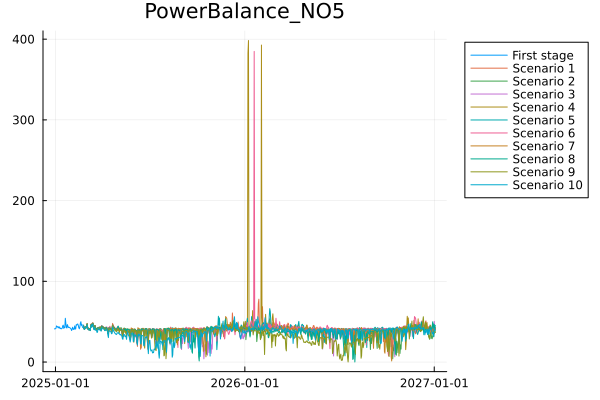

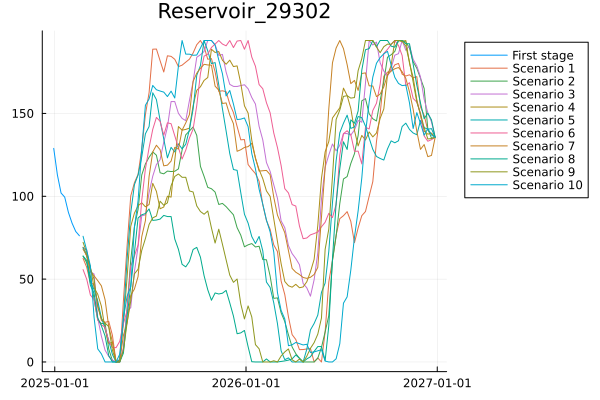

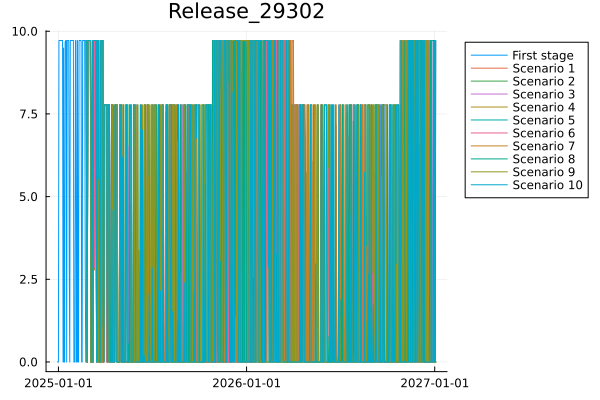

In [11]:
concept = BALANCE_CONCEPT
instance = "PowerBalance_NO5"
id = Id(concept, instance)

plot_price(prob, id, t)

concept = STORAGE_CONCEPT
instance = "Reservoir_29302"
id = Id(concept, instance)

plot_var(prob, id, datayear)

concept = FLOW_CONCEPT
instance = "Release_29302"
id = Id(concept, instance)

plot_var(prob, id, datayear)

### If we instead use FixedDataTwoTime see that the scenarios are not smoothed between first-stage and second stage problems

In [12]:
datayear = getisoyearstart(2025)
scenarioyear = getisoyearstart(1981)
t = FixedDataTwoTime(datayear, scenarioyear)

@time update!(prob, t)

@time solve!(prob)
println(getobjectivevalue(prob))

  0.752058 seconds (1.98 M allocations: 53.936 MiB, 84.21% compilation time)
  0.627273 seconds
-2.6471999506765833e8


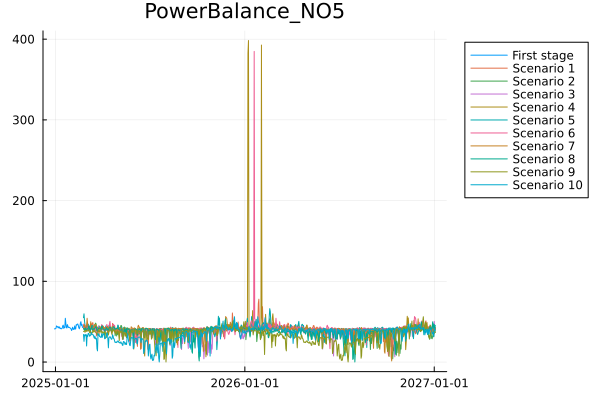

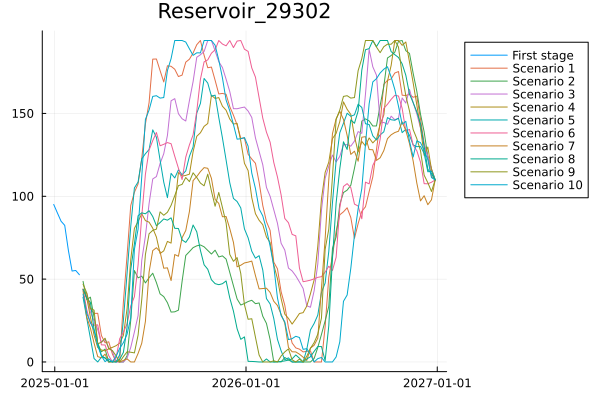

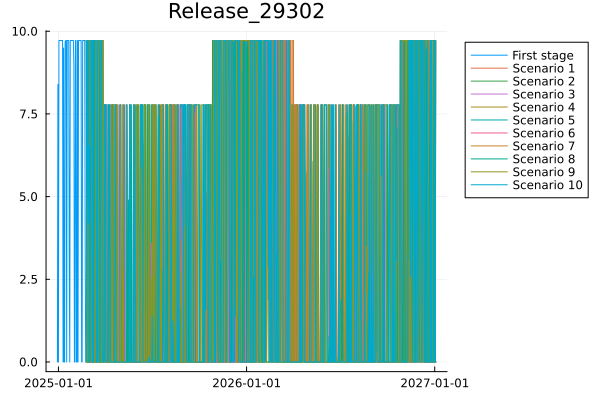

In [13]:
concept = BALANCE_CONCEPT
instance = "PowerBalance_NO5"
id = Id(concept, instance)

plot_price(prob, id, t)

concept = STORAGE_CONCEPT
instance = "Reservoir_29302"
id = Id(concept, instance)

plot_var(prob, id, datayear)

concept = FLOW_CONCEPT
instance = "Release_29302"
id = Id(concept, instance)

plot_var(prob, id, datayear)